In [17]:
import numpy as np
import matplotlib.pyplot as plt
import freqopttest.util as util
import freqopttest.data as data
import freqopttest.kernel as kernel
import freqopttest.tst as tst
import collections
from collections import defaultdict
import freqopttest.glo as glo
import sys
import time
import os
import pandas as pd
import pickle

mfdfaDataFrames = '/media/ak/T7/August11th2022Experiments/mfdfaDataFrames'  # Input Files
LinearMMDOutputFiles = '/media/ak/T7/August11th2022Experiments/ExperimentOne/TestMMDOutputFiles'  # Location to Save Files

symbol = 'US1'
symbol_mfdfa_Frames_loc = os.path.join(mfdfaDataFrames, symbol)
bar_choice = 'tick'
variable = 'tau'

23


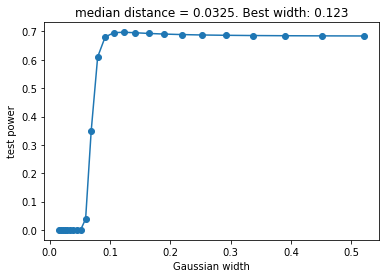

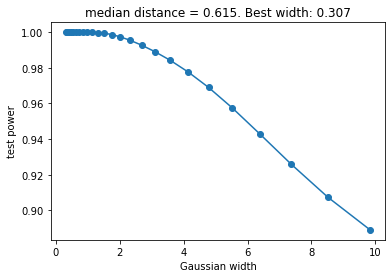

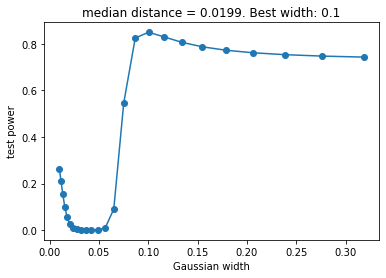

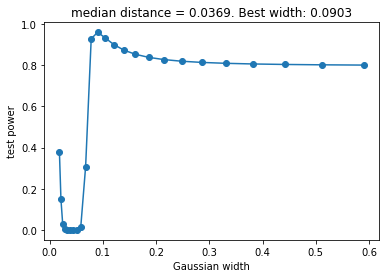

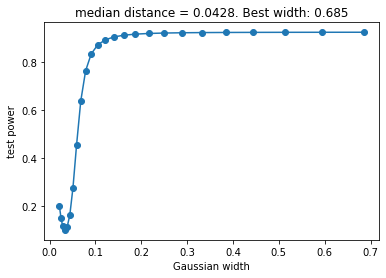

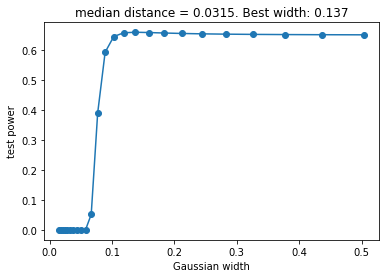

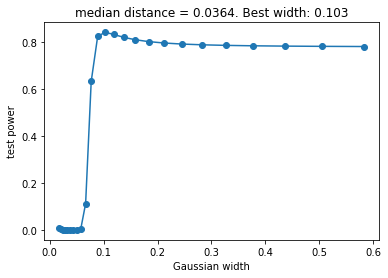

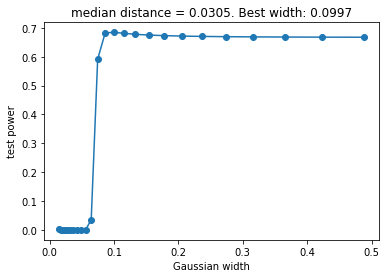

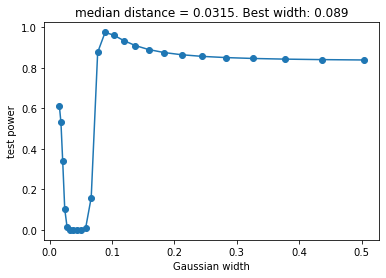

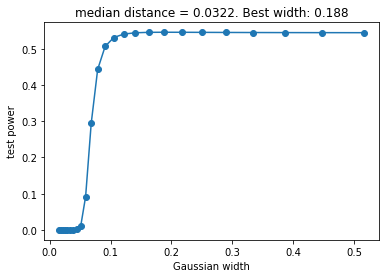

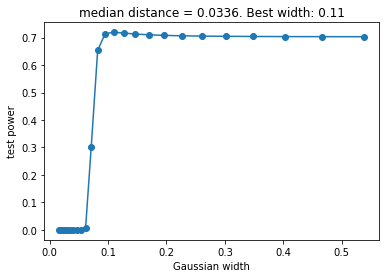

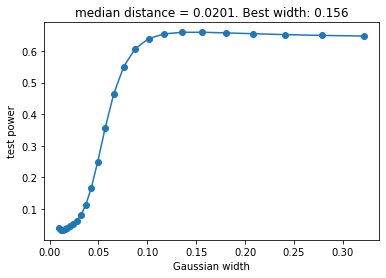

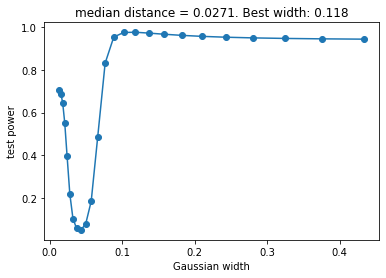

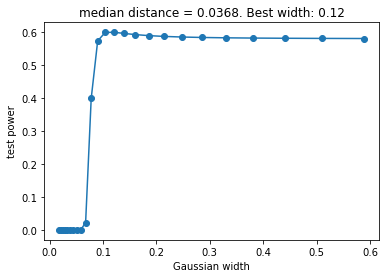

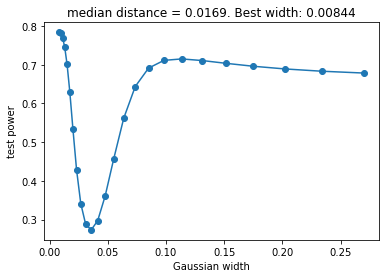

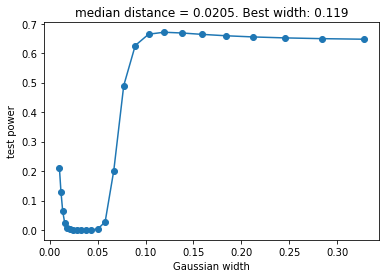

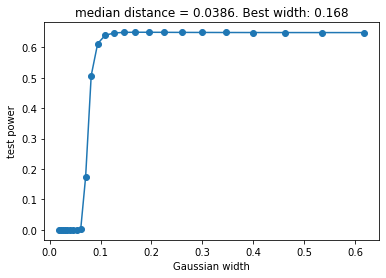

defaultdict(<class 'dict'>, {0: {'widths': [0.0162728267049298, 0.018800854219275787, 0.021721617625742734, 0.025096129504330166, 0.028994880903883677, 0.03349931384779238, 0.038703522597417606, 0.0447162192113834, 0.05166300445980355, 0.059688991531158295, 0.06896183733911, 0.07967524475100778, 0.09205300889703523, 0.10635369208439699, 0.12287602497203139, 0.1419651468323812, 0.16401981525465986, 0.1895007358949633, 0.21894018627552614, 0.252953134667147, 0.29225008631998356, 0.33765192539094746, 0.39010706260454686, 0.45071124684908376, 0.5207304545577536], 'med': 0.0325456534098596, 'besti': 14, 'powers': array([6.14964214e-04, 1.27502990e-04, 4.12440354e-05, 2.21640581e-05,
       1.84700660e-05, 2.27095661e-05, 4.30568046e-05, 1.52210668e-04,
       1.47482342e-03, 3.87021627e-02, 3.49788210e-01, 6.10448820e-01,
       6.80418616e-01, 6.95705475e-01, 6.97327139e-01, 6.95532847e-01,
       6.93137649e-01, 6.90935153e-01, 6.89112586e-01, 6.87669127e-01,
       6.86550501e-01, 6.8569

In [19]:


file_name = [f for f in os.listdir(symbol_mfdfa_Frames_loc ) if str(variable) in f][0]
file_loc = os.path.join(symbol_mfdfa_Frames_loc, file_name)
unpickled_Df = pd.read_pickle(file_loc)
len = unpickled_Df.shape[1]
print(len)
test_results_one_dict = defaultdict(dict)
test_results_two_dict = defaultdict(dict)
if __name__ == '__main__':
    shift = 1
    window = 5  # slide
    for start_point in range(0, (len-window-shift)):
        end_point = start_point + shift

        X = np.array(unpickled_Df.iloc[:, start_point:end_point])
        Y = np.array(unpickled_Df.iloc[:, end_point + shift:end_point + 2 * shift])
        Z = np.array(unpickled_Df.iloc[:, start_point + window:end_point + window])

        data_sample = data.TSTData(X, Y)  # data to train the model
        test_data_one = data_sample = data.TSTData(X, Z)
        test_data_two = data_sample = data.TSTData(Y, Z)

        tr, te = data_sample.split_tr_te(tr_proportion=0.9, seed=100)

        # choose the best kernel that maximizes the test power
        med = util.meddistance(tr.stack_xy())

        widths = [(med * f) for f in 2.0 ** np.linspace(-1, 4, 25)]
        list_kernels = [kernel.KGauss(w ** 2) for w in widths]

        besti, powers = tst.LinearMMDTest.grid_search_kernel(tr, list_kernels, alpha=0.01)
        # print(list_kernels)
        plt.plot(widths, powers, 'o-')
        plt.xlabel('Gaussian width')
        plt.ylabel('test power')
        plt.title('median distance = %.3g. Best width: %.3g' % (med, widths[besti]))
        plt.show()
        test_data_one = data_sample = data.TSTData(X, Z)
        test_data_two = data_sample = data.TSTData(Y, Z)

        # The actual test
        best_ker = list_kernels[besti]
        lin_mmd_test = tst.LinearMMDTest(best_ker, alpha=0.01)
        # test_result_one = lin_mmd_test.perform_test(test_data_one)
        # test_result_two = lin_mmd_test.perform_test(test_data_two)

        # Test 1 Results Dict
        test_results_one_dict[start_point]['widths'] = widths
        test_results_one_dict[start_point]['med'] = med
        test_results_one_dict[start_point]['widths'] = widths
        test_results_one_dict[start_point]['besti'] = besti
        test_results_one_dict[start_point]['powers'] = powers

        test_results_one_dict[start_point]['med_on_test_data'] = util.meddistance(test_data_one.stack_xy())
        test_results_one_dict[start_point]['test_result'] = lin_mmd_test.perform_test(test_data_one)
        test_results_one_dict[start_point]['test_variance'] = lin_mmd_test.variance(X, Z, best_ker)  # test variance
        test_results_one_dict[start_point]['two_moments'] = lin_mmd_test.two_moments(X, Z, best_ker)  # test variance
        test_results_one_dict[start_point]['compute_unbiased_linear_estimator'] = lin_mmd_test.compute_stat(test_data_one)

        # Test 2 Results Dict
        test_results_two_dict[start_point]['test_result'] = lin_mmd_test.perform_test(test_data_two)
        test_results_two_dict[start_point]['test_variance'] = lin_mmd_test.variance(Y, Z, best_ker)
        test_results_two_dict[start_point]['med_on_test_data'] = util.meddistance(test_data_two.stack_xy())  # test variance
        test_results_two_dict[start_point]['two_moments'] = lin_mmd_test.two_moments(Y, Z, best_ker)  # test variance
        test_results_two_dict[start_point]['compute_unbiased_linear_estimator'] = lin_mmd_test.compute_stat(test_data_two)

        # need a better hash file below

    pickle_out_dict_one = os.path.join(LinearMMDOutputFiles, "".join(
        (str(symbol) + "_" + str(variable) + "_shift_" + str(shift) + "_wind_" + str(window) + "_" + str(
            'linear_test') + "_ONE.pkl")))
    pickle.dump(test_results_one_dict, open(pickle_out_dict_one, 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

    pickle_out_dict_two = os.path.join(LinearMMDOutputFiles, "".join(
        (str(symbol) + "_" + str(variable) + "_shift_" + str(shift) + "_wind_" + str(window) + "_" + str(
            'linear_test') + "_TWO.pkl")))
    pickle.dump(test_results_two_dict, open(pickle_out_dict_two, 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

    print(test_results_one_dict)


In [20]:
pickle_out_dict_two

'/media/ak/T7/August11th2022Experiments/ExperimentOne/TestMMDOutputFiles/US1_tau_shift_1_wind_5_linear_test_TWO.pkl'

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import freqopttest.util as util
import freqopttest.data as data
import freqopttest.kernel as kernel
import freqopttest.tst as tst
import collections
from collections import defaultdict
import freqopttest.glo as glo
import sys
import time
import os
import pandas as pd
import pickle

mfdfaDataFrames = '/media/ak/T7/August11th2022Experiments/mfdfaDataFrames'  # Input Files
LinearMMDOutputFiles = '/media/ak/T7/August11th2022Experiments/ExperimentOne/TestMMDOutputFiles'  # Location to Save Files

symbol = 'RX1'
symbol_mfdfa_Frames_loc = os.path.join(mfdfaDataFrames, symbol)
bar_choice = 'dollar'
variable = 'mfSpect'

def simulate_null_spectral(weights, n_simulate=1000, seed=275):
    """
    weights: chi-square weights (for the infinite weigted sum of chi squares)
    Return the values of MMD^2 (NOT n*MMD^2) simulated from the null distribution by
    the spectral method.
    """
    # draw at most block_size values at a time
    block_size = 400
    D = chi2_weights.shape[0]  # len(weights)
    mmds = np.zeros(n_simulate)
    from_ind = 0

    with util.NumpySeedContext(seed=seed):
        while from_ind < n_simulate:
            to_draw = min(block_size, n_simulate - from_ind)
            # draw chi^2 random variables.
            chi2 = np.random.randn(D, to_draw) ** 2
            # an array of length to_draw
            sim_mmds = 2.0 * weights.dot(chi2 - 1.0)
            # store
            end_ind = from_ind + to_draw
            mmds[from_ind:end_ind] = sim_mmds
            from_ind = end_ind
    return mmds


def chi_square_weights_H0(k, X):
    """
    Return a numpy array of the weights to be used as the weights in the
    weighted sum of chi-squares for the null distribution of MMD^2.
    - k: a Kernel
    - X: n x d number array of n data points
    """
    n = X.shape[0]
    # Gram matrix
    K = k.eval(X, X)
    # centring matrix. Not the most efficient way.
    H = np.eye(n) - np.ones((n, n)) / float(n)
    HKH = H.dot(K).dot(H)
    # https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.eigvals.html
    evals = np.linalg.eigvals(HKH)
    evals = np.real(evals)
    # sort in decreasing order
    evals = -np.sort(-evals)
    weights = evals / float(n) ** 2
    return weights
#-------# #----------------# FILES & Locations #-----------------#
t7 ='/media/ak/T7'
experimentFiles = os.path.join(t7,'August11th2022Experiments')

file_name = [f for f in os.listdir(symbol_mfdfa_Frames_loc ) if str(variable) in f][0]
file_loc = os.path.join(symbol_mfdfa_Frames_loc, file_name)
unpickled_Df = pd.read_pickle(file_loc)

print(len)

mmd_train_test_results = defaultdict(dict)

if __name__ == '__main__':

    shift = 2
    window = 8  # slide
    start = time.time()
    
def quad_main_compute(unpickled_Df, shift, window):
    length = unpickled_Df.shape[1]
    start_point =(length - window - shift)

    end_point = start_point + shift

    X = np.array(unpickled_Df.iloc[:, start_point:end_point])
    Y = np.array(unpickled_Df.iloc[:, end_point + shift:end_point + 2 * shift])
    Z = np.array(unpickled_Df.iloc[:, start_point + window:end_point + window])

    tr_data = data.TSTData(X, Y)
    test_data_one = data.TSTData(X, Z)  # data to train the model
    test_data_two = data.TSTData(Y, Z)
    # training dictionary results
    tr, te = tr_data.split_tr_te(tr_proportion=0.95, seed=10)  # is this necessary?!

    xtr, ytr = tr.xy()
    xytr = tr.stack_xy()
    sig2 = util.meddistance(xytr, subsample=1000)
    k = kernel.KGauss(sig2)
    mean, var = tst.QuadMMDTest.h1_mean_var(xtr, ytr, k, is_var_computed=True)
    Kx = k.eval(xtr, xtr)
    Ky = k.eval(ytr, ytr)
    Kxy = k.eval(xtr, ytr)
    mean_gram, var_gram = tst.QuadMMDTest.h1_mean_var_gram(Kx, Ky, Kxy, k, True)
    chi2_weights = chi_square_weights_H0(k, xytr)
    sim_mmds = simulate_null_spectral(chi2_weights, n_simulate=2000)
    # choose the best parameter and perform a test with permutations
    med = util.meddistance(tr.stack_xy(), 1000)
    list_gwidth = np.hstack(((med ** 2) * (2.0 ** np.linspace(-4, 4, 20))))
    list_gwidth.sort()
    list_kernels = [kernel.KGauss(gw2) for gw2 in list_gwidth]

    # grid search to choose the best Gaussian width
    besti, powers = tst.QuadMMDTest.grid_search_kernel(tr, list_kernels, alpha=0.05)
    # perform test
    best_ker = list_kernels[besti]
    mmd_train_test_results[start_point]['perm_mmds1'] = tst.QuadMMDTest.permutation_list_mmd2(xtr, ytr, k,
                                                                                              n_permute=2000)
    mmd_train_test_results[start_point]['chi2_weights'] = chi2_weights
    mmd_train_test_results[start_point]['sim_mmds'] = sim_mmds
    mmd_train_test_results[start_point]['sig2'] = sig2
    mmd_train_test_results[start_point]['Kxy'] = k.eval(xtr, ytr)
    mmd_train_test_results[start_point]['mean'] = mean
    mmd_train_test_results[start_point]['var'] = var
    mmd_train_test_results[start_point]['Kxx'] = k.eval(xtr, xtr)
    mmd_train_test_results[start_point]['Kyy'] = k.eval(ytr, ytr)
    mmd_train_test_results[start_point]['mean_gram'] = mean_gram
    mmd_train_test_results[start_point]['var_gram'] = var_gram
    mmd_train_test_results[start_point]['med'] = util.meddistance(tr.stack_xy(), 1000)
    mmd_train_test_results[start_point]['list_gwidth'] = list_gwidth.sort()
    mmd_train_test_results[start_point]['list_kernels'] = list_kernels
    mmd_train_test_results[start_point]['besti'] = besti
    mmd_train_test_results[start_point]['powers'] = powers
    mmd_train_test_results[start_point]['best_ker'] = best_ker

    alpha = 0.05
    mmd_test = tst.QuadMMDTest(best_ker, n_permute=2000, alpha=alpha)
    mmd_train_test_results[start_point]['XZ_test'] = mmd_test.perform_test(test_data_one)
    mmd_train_test_results[start_point]['YZ_test'] = mmd_test.perform_test(test_data_two)

    # testing the first data set
    pickle_out_dict_one = os.path.join(LinearMMDOutputFiles, "".join(
        (str(symbol) + "_" + str(variable) + "_shift_" + str(shift) + "_wind_" + str(window) + "_" + str(
            'quad_MMD_test') + ".pkl")))
    pickle.dump(mmd_train_test_results, open(pickle_out_dict_one, 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

    end = time.time()
    print(end - start)


23


In [37]:
# quad_main_compute(unpickled_Df, shift, window)

In [40]:
import itertools
import multiprocessing as mp
from multiprocessing import Pool
from multiprocessing import Pool, freeze_support
freeze_support()
df_args = [unpickled_Df]
a_args = [1, 2, 3]  # symbol
second_arg = [5]  # range of files

freeze_support()
# produces simple standarised returns and calculates jB statistic
with Pool() as pool:
    L = pool.starmap(quad_main_compute, list(itertools.product(df_args, a_args, second_arg)))

ValueError: Dimension sizes of the two datasets must be the same.

In [46]:
a_args =[1, 2, 3]
second_arg = [1, 4, 5, 6, 8, 10]
c = list(itertools.product(a_args, second_arg))

In [54]:
bars =['tick', 'dollar', 'volume']
variables =['alpha', 'tau', 'mfSpect']
c = list(itertools.product(variables, bars))
for var, bar in c:
    print (bar)

tick
dollar
volume
tick
dollar
volume
tick
dollar
volume
